In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzipping the dataset
import os
import zipfile

zip_path = "/content/drive/MyDrive/CIP/Dataset/archive.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf

DATASET_PATH = "/content/dataset/boss_256_0.4/cover"
IMAGE_SIZE = (256, 256)
MIN_SIZE_BYTES = 7 * 1024
def load_images(dataset_path, image_size, min_size_bytes):
    images = []
    valid_extensions = (".png", ".jpg", ".jpeg", ".bmp", ".tiff")
    filenames = [
        f for f in os.listdir(dataset_path)
        if f.lower().endswith(valid_extensions) and os.path.getsize(os.path.join(dataset_path, f)) > min_size_bytes
    ]

    for filename in filenames:
        img_path = os.path.join(dataset_path, filename)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Warning: Could not read {img_path}")
            continue

        img = cv2.resize(img, image_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)
        images.append(img)

    return np.stack(images, axis=0) if images else np.array([])

cover_images = load_images(DATASET_PATH, IMAGE_SIZE, MIN_SIZE_BYTES)

print("Cover Images Shape:", cover_images.shape)
print("Min Pixel Value:", np.min(cover_images), "Max Pixel Value:", np.max(cover_images))
print(f"Total Images Loaded: {cover_images.shape[0]}")


Cover Images Shape: (6357, 256, 256, 1)
Min Pixel Value: 0.0 Max Pixel Value: 1.0
Total Images Loaded: 6357


In [ ]:
!pip install Faker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import struct
from faker import Faker

fake = Faker()
MAX_BITS = 16384  # Ensuring each message fits within this

def generate_patient_info():
    """Generate and pack structured patient data into binary format."""
    patient_id = int(fake.random_number(digits=8))
    age = fake.random_int(min=18, max=99)
    gender = fake.random_element(elements=("M", "F", "O")).encode()
    blood_type = fake.random_element(elements=("A+", "A-", "B+", "B-", "O+", "O-", "AB+", "AB-")).encode()

    allergies = ",".join(fake.words(3))[:30].encode()
    chronic_conditions = ",".join(fake.words(5))[:50].encode()
    medications = ",".join(fake.sentences(3))[:80].encode()
    treatments = ",".join(fake.sentences(3))[:80].encode()
    visits = ",".join([fake.date_this_decade().isoformat() for _ in range(3)])[:50].encode()

    hemoglobin = round(fake.pyfloat(min_value=10.0, max_value=18.0, right_digits=1), 1)
    cholesterol = round(fake.pyfloat(min_value=100.0, max_value=250.0, right_digits=1), 1)
    systolic_bp = fake.random_int(90, 140)
    diastolic_bp = fake.random_int(60, 90)
    heart_rate = fake.random_int(60, 100)

    # Pack all fields into binary format (Big-endian for consistency)
    binary_data = struct.pack(
        ">I B c 2s 30s 50s 80s 80s 50s f f H H H",
        patient_id, age, gender, blood_type,
        allergies, chronic_conditions, medications, treatments, visits,
        hemoglobin, cholesterol, systolic_bp, diastolic_bp, heart_rate
    )

    bit_array = np.unpackbits(np.frombuffer(binary_data, dtype=np.uint8))

    return np.pad(bit_array, (0, max(0, MAX_BITS - len(bit_array))), 'constant')

num_images = len(cover_images)
binary_messages = [generate_patient_info() for _ in range(num_images)]

binary_messages = np.array(binary_messages, dtype=np.uint8)

print(f"Created {len(binary_messages)} messages, each {len(binary_messages[0])} bits long.")
print(binary_messages.shape)


Created 6357 messages, each 16384 bits long.
(6357, 16384)


In [ ]:
def decode_patient_info(binary_message):
    """Decode binary bit array back to structured patient info."""
    byte_array = np.packbits(binary_message)  # Convert bits to bytes
    buffer_size = struct.calcsize(">I B c 2s 30s 50s 80s 80s 50s f f H H H")
    unpacked_data = struct.unpack(">I B c 2s 30s 50s 80s 80s 50s f f H H H", byte_array[:buffer_size])

    # Convert back to readable format
    patient_info = {
        "patient_id": unpacked_data[0],
        "age": unpacked_data[1],
        "gender": unpacked_data[2].decode(),
        "blood_type": unpacked_data[3].decode(),
        "allergies": unpacked_data[4].decode().strip(),
        "chronic_conditions": unpacked_data[5].decode().strip(),
        "current_medications": unpacked_data[6].decode().strip(),
        "recent_treatments": unpacked_data[7].decode().strip(),
        "hospital_visits": unpacked_data[8].decode().strip(),
        "lab_results": {
            "hemoglobin": unpacked_data[9],
            "cholesterol": unpacked_data[10],
            "blood_pressure": f"{unpacked_data[11]}/{unpacked_data[12]}",
            "heart_rate": unpacked_data[13]
        }
    }

    return patient_info

# Example
decoded_message = decode_patient_info(binary_messages[0])
print(decoded_message)


{'patient_id': 86872225, 'age': 98, 'gender': 'O', 'blood_type': 'A-', 'allergies': 'large,team,heart\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'chronic_conditions': 'determine,section,describe,drug,save\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'current_medications': 'Choose possible citizen risk conference artist foreign necessary.,Both fast soon', 'recent_treatments': 'Science production also center already.,Maybe although design list benefit broth', 'hospital_visits': '2024-06-01,2024-04-29,2023-06-23\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'lab_results': {'hemoglobin': 16.600000381469727, 'cholesterol': 247.60000610351562, 'blood_pressure': '123/61', 'heart_rate': 95}}


In [ ]:
def decode_patient_info(binary_message):
    """Decode a 16384-bit array to original structured data."""
    byte_array = np.packbits(binary_message)
    decoded_bytes = rs.decode(byte_array)  # 1600 bytes

    unpack_format = ">I B c 2s 100s 200s 400s 400s 400s d d H H H"
    buffer_size = struct.calcsize(unpack_format)
    unpacked_data = struct.unpack(unpack_format, decoded_bytes[:buffer_size])

    patient_info = {
        "patient_id": unpacked_data[0],
        "age": unpacked_data[1],
        "gender": unpacked_data[2].decode(),
        "blood_type": unpacked_data[3].decode(),
        "allergies": unpacked_data[4].decode().strip(),
        "chronic_conditions": unpacked_data[5].decode().strip(),
        "current_medications": unpacked_data[6].decode().strip(),
        "recent_treatments": unpacked_data[7].decode().strip(),
        "hospital_visits": unpacked_data[8].decode().strip(),
        "lab_results": {
            "hemoglobin": unpacked_data[9],
            "cholesterol": unpacked_data[10],
            "blood_pressure": f"{unpacked_data[11]}/{unpacked_data[12]}",
            "heart_rate": unpacked_data[13]
        }
    }

    return patient_info


In [ ]:

def create_dataset(images, messages, batch_size):
    # Convert each message to a fixed-length array
    messages = np.array(messages, dtype=np.uint8)

    dataset = tf.data.Dataset.from_tensor_slices((images, messages))
    dataset = dataset.shuffle(len(images)).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

BATCH_SIZE = 32

dataset = create_dataset(cover_images, binary_messages, BATCH_SIZE)


In [ ]:
for batch_cover, batch_message in dataset.take(1):
    print("Cover Image Batch Shape:", batch_cover.shape)
    print("Message Batch Shape:", batch_message.shape)


Cover Image Batch Shape: (32, 256, 256, 1)
Message Batch Shape: (32, 16384)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_simplified_unet_generator_v4(input_shape=(256, 256, 1), message_length=16384):
    def conv_block(x, filters, kernel_size=3, strides=1, padding='same', activation='relu'):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        return x

    def encoder_block(x, filters, pool_size=(2, 2), pool_strides=(2, 2)):
        conv = conv_block(x, filters)
        pool = layers.MaxPooling2D(pool_size=pool_size, strides=pool_strides)(conv)
        return conv, pool

    def decoder_block(x, skip_connection, filters, kernel_size=3, strides=1, padding='same', activation='relu'):
        up = layers.UpSampling2D(size=(2, 2))(x)
        up = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(up)
        up = layers.BatchNormalization()(up)
        up = layers.Activation(activation)(up)
        concat = layers.Concatenate()([up, skip_connection])
        conv = conv_block(concat, filters)
        return conv

    cover_input = layers.Input(shape=input_shape, name='cover_image')
    message_input = layers.Input(shape=(message_length,), name='message')

    # Message embedding block
    message_embedding = layers.Dense(16 * 16, activation='relu')(message_input)
    message_embedding = layers.Reshape((16,16, 1))(message_embedding)

    # Encoder
    enc1, pool1 = encoder_block(cover_input, 4)
    enc2, pool2 = encoder_block(pool1, 8)

    bottleneck = conv_block(pool2, 16)
    message_embedding_upsampled = layers.UpSampling2D(size=(4, 4))(message_embedding)

    bottleneck_with_message = layers.Concatenate()([bottleneck, message_embedding_upsampled])

    noise_input = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(bottleneck_with_message)
    noise_output = layers.Conv2D(32, (3, 3), padding='same', activation='tanh')(noise_input)  # Trainable noise
    bottleneck_with_adaptive_noise = layers.Add()([bottleneck_with_message, noise_output])

    dec2 = decoder_block(noise, enc2, 8)
    dec1 = decoder_block(dec2, enc1, 4)

    stego_image = layers.Conv2D(1, (1, 1), activation='sigmoid')(dec1)

    generator = Model(inputs=[cover_input, message_input], outputs=stego_image)

    return generator

generator = build_simplified_unet_generator_v4()
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cover_image (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 4)    │             40 │ cover_image[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 4)    │             16 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 4)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 4)    │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 8)    │            296 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 8)    │             32 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 8)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 8)      │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ message (InputLayer)      │ (None, 16384)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 16)     │          1,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      4,194,560 │ message[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 16)     │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 16, 16, 1)      │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 16)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 1)      │              0 │ reshape[0][0]          │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 4,199,253 (16.02 MB)

 Trainable params: 4,199,149 (16.02 MB)

 Non-trainable params: 104 (416.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_simplified_discriminator_with_xunet(input_shape=(256, 256, 1)):
    def conv_block(x, filters, kernel_size=3, strides=1, padding='same', activation='relu'):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        return x

    def srnet_block(x, filters, kernel_size=3, strides=1, padding='same'):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        return x

    def xunet_block(x, filters, kernel_size=3, strides=1, padding='same'):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        return x

    input_image = layers.Input(shape=input_shape, name='input_image')

    x = conv_block(input_image, 32, activation='relu')

    x = srnet_block(x, 32)
    x = srnet_block(x, 64)

    x = xunet_block(x, 64)
    x = xunet_block(x, 32)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    discriminator = Model(inputs=input_image, outputs=x)

    return discriminator

discriminator = build_simplified_discriminator_with_xunet()
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 64)          │          36,9

 Total params: 176,737 (690.38 KB)

 Trainable params: 176,289 (688.63 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_improved_extractor(input_shape=(256, 256, 1), message_length=16384):
    def conv_block(x, filters, kernel_size=3, strides=1, padding='same', activation='relu'):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        return x

    def encoder_block(x, filters, pool_size=(2, 2), pool_strides=(2, 2)):
        conv = conv_block(x, filters)
        pool = layers.MaxPooling2D(pool_size=pool_size, strides=pool_strides)(conv)
        return conv, pool

    def decoder_block(x, skip_connection, filters, kernel_size=3, strides=1, padding='same', activation='relu'):
        up = layers.UpSampling2D(size=(2, 2))(x)
        up = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(up)
        up = layers.BatchNormalization()(up)
        up = layers.Activation(activation)(up)
        x = layers.Add()([up, skip_connection])
        conv = conv_block(x, filters)
        return conv

    stego_input = layers.Input(shape=input_shape, name='stego_image')

    enc1, pool1 = encoder_block(stego_input, 8)
    enc2, pool2 = encoder_block(pool1, 16)
    enc3, pool3 = encoder_block(pool2, 32)

    bottleneck = conv_block(pool3, 64)

    dec3 = decoder_block(bottleneck, enc3, 32)
    dec2 = decoder_block(dec3, enc2, 16)
    dec1 = decoder_block(dec2, enc1, 8)

    # Final message recovery layer
    x = layers.GlobalAveragePooling2D()(dec1)
    recovered_message = layers.Dense(message_length, activation='sigmoid')(x)
    extractor = Model(inputs=stego_input, outputs=recovered_message)

    return extractor

# Example usage
extractor = build_improved_extractor()
extractor.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ stego_image (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 256, 256, 8)    │             80 │ stego_image[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 256, 256, 8)    │             32 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16             │ (None, 256, 256, 8)    │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 128, 128, 8)    │              0 │ activation_16[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 128, 128, 16)   │          1,168 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 128, 128, 16)   │             64 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 64, 64, 16)     │              0 │ activation_17[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 64, 64, 32)     │            128 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 64, 64, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 32, 32, 32)     │              0 │ activation_18[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 32, 32, 64)     │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization) 

 Total params: 209,168 (817.06 KB)

 Trainable params: 208,704 (815.25 KB)

 Non-trainable params: 464 (1.81 KB)

In [ ]:
print("Trainable variables :", len(generator.trainable_variables))  # Should NOT be 0
for layer in generator.layers:
    print(layer.name, "Trainable:", layer.trainable)
print("\nTrainable variables:", len(discriminator.trainable_variables))  # Should NOT be 0
for layer in discriminator.layers:
    print(layer.name, "Trainable:", layer.trainable)
print("\nTrainable variables:", len(extractor.trainable_variables))  # Should NOT be 0
for layer in extractor.layers:
    print(layer.name, "Trainable:", layer.trainable)


Trainable variables : 32
cover_image Trainable: True
conv2d Trainable: True
batch_normalization Trainable: True
activation Trainable: True
max_pooling2d Trainable: True
conv2d_1 Trainable: True
batch_normalization_1 Trainable: True
activation_1 Trainable: True
max_pooling2d_1 Trainable: True
message Trainable: True
conv2d_2 Trainable: True
dense Trainable: True
batch_normalization_2 Trainable: True
reshape Trainable: True
activation_2 Trainable: True
up_sampling2d Trainable: True
concatenate Trainable: True
gaussian_noise Trainable: True
up_sampling2d_1 Trainable: True
conv2d_3 Trainable: True
batch_normalization_3 Trainable: True
activation_3 Trainable: True
concatenate_1 Trainable: True
conv2d_4 Trainable: True
batch_normalization_4 Trainable: True
activation_4 Trainable: True
up_sampling2d_2 Trainable: True
conv2d_5 Trainable: True
batch_normalization_5 Trainable: True
activation_5 Trainable: True
concatenate_2 Trainable: True
conv2d_6 Trainable: True
batch_normalization_6 Trainable

In [ ]:
# import tensorflow as tf

# def generator_mse_loss_fn(cover_image, stego_image):
#     mse = tf.keras.losses.MeanSquaredError()
#     return mse(cover_image, stego_image)

# def generator_bce_loss_fn(fake_output):
#     bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)  # Fixed
#     return bce(tf.ones_like(fake_output), fake_output)

# def ber_loss_fn(original_message, extracted_message):
#     original_message = tf.cast(original_message, tf.float32)
#     return tf.reduce_mean(tf.abs(original_message - extracted_message))

# def generator_combined_loss_fn(cover_image, stego_image, fake_output, original_message, extracted_message,
#                                mse_weight=1.0, bce_weight=0.2, ber_weight=0.5):
#     mse_loss = generator_mse_loss_fn(cover_image, stego_image)
#     bce_loss = generator_bce_loss_fn(fake_output)
#     ber_loss = ber_loss_fn(original_message, extracted_message)

#     return (mse_weight * mse_loss) + (bce_weight * bce_loss) + (ber_weight * ber_loss)

# def discriminator_loss_fn(real_output, fake_output):

#     bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)  # Fixed
#     real_loss = bce(tf.ones_like(real_output), real_output)
#     fake_loss = bce(tf.zeros_like(fake_output), fake_output)

#     return real_loss + fake_loss

# def extractor_loss_fn(original_message, extracted_message):
#     bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)  # Ensure consistency with extractor activation
#     return bce(original_message, extracted_message)


In [ ]:
import tensorflow as tf

def generator_mse_loss_fn(cover_image, stego_image):
    mse = tf.keras.losses.MeanSquaredError()
    return mse(cover_image, stego_image)

def generator_bce_loss_fn(fake_output):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    return bce(tf.ones_like(fake_output), fake_output)

def ber_loss_fn(original_message, extracted_message):
    return tf.reduce_mean(tf.abs(tf.cast(original_message, tf.float32) - extracted_message))

def generator_combined_loss_fn(cover_image, stego_image, fake_output, original_message, extracted_message,
                               mse_weight=1.2, bce_weight=0.4, ber_weight=1.0):  # Tweaked weights
    mse_loss = generator_mse_loss_fn(cover_image, stego_image)
    bce_loss = generator_bce_loss_fn(fake_output)
    ber_loss = ber_loss_fn(original_message, extracted_message)

    return (mse_weight * mse_loss) + (bce_weight * bce_loss) + (ber_weight * ber_loss)

def discriminator_loss_fn(real_output, fake_output):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    # Label smoothing: Use 0.9 instead of 1.0 for real labels
    real_loss = bce(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)

    return real_loss + fake_loss

def extractor_loss_fn(original_message, extracted_message):
    mse = tf.keras.losses.MeanSquaredError()  # Changed from BCE
    return mse(original_message, extracted_message)


In [ ]:
strategy = tf.distribute.get_strategy()

In [ ]:
with strategy.scope():
    generator = tf.keras.models.load_model("/content/drive/MyDrive/CIP/Saved_Models/new2/generator_model_updated_new.keras")  # or generator.h5
    discriminator = tf.keras.models.load_model("/content/drive/MyDrive/CIP/Saved_Models/new1/discriminator_model_updated_new.keras")
    extractor = tf.keras.models.load_model("/content/drive/MyDrive/CIP/Saved_Models/new2/extractor_model_updated_new.keras")

    # gen_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
    # disc_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    # extractor_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

    # generator.compile(optimizer=gen_optimizer, loss=tf.keras.losses.MeanSquaredError())
    # discriminator.compile(optimizer=disc_optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    # extractor.compile(optimizer=extractor_optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5)  # Reduced LR
    extractor_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, beta_1=0.5)  # Reduced LR

    generator.compile(optimizer=gen_optimizer, loss=tf.keras.losses.MeanSquaredError())
    discriminator.compile(optimizer=disc_optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    extractor.compile(optimizer=extractor_optimizer, loss="mean_squared_error", metrics=["accuracy"])


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 62 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
@tf.function
def train_step(cover_image, message):
    with tf.GradientTape(persistent=True) as tape:
        stego_image = generator([cover_image, message], training=True)

        tf.print("Stego Image Shape:", tf.shape(stego_image))

        extracted_message_batch = extractor(stego_image, training=True)

        real_output = discriminator(cover_image, training=True)
        fake_output = discriminator(stego_image, training=True)

        gen_loss = generator_combined_loss_fn(cover_image, stego_image, fake_output, message, extracted_message_batch)
        disc_loss = discriminator_loss_fn(real_output, fake_output)
        ber_loss = ber_loss_fn(message, extracted_message_batch)
        extractor_loss = extractor_loss_fn(message, extracted_message_batch)

        tf.print("BER Loss:", ber_loss)
        tf.print("Gen Loss:", gen_loss, "Disc Loss:", disc_loss, "Extractor Loss:", extractor_loss)

        tf.debugging.check_numerics(gen_loss, "\u26a0\ufe0f Gen loss has NaN!")
        tf.debugging.check_numerics(extractor_loss, "\u26a0\ufe0f Extractor loss has NaN!")
        tf.debugging.check_numerics(disc_loss, "\u26a0\ufe0f Disc loss has NaN!")

    gen_gradients = tape.gradient(gen_loss, generator.trainable_variables)
    extractor_gradients = tape.gradient(extractor_loss, extractor.trainable_variables)
    disc_gradients = tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_gradients = [tf.clip_by_norm(g, 1.0) if g is not None else tf.zeros_like(v) for v, g in zip(generator.trainable_variables, gen_gradients)]
    extractor_gradients = [tf.clip_by_norm(g, 1.0) if g is not None else tf.zeros_like(v) for v, g in zip(extractor.trainable_variables, extractor_gradients)]
    disc_gradients = [tf.clip_by_norm(g, 1.0) if g is not None else tf.zeros_like(v) for v, g in zip(discriminator.trainable_variables, disc_gradients)]

    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    extractor_optimizer.apply_gradients(zip(extractor_gradients, extractor.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss, extractor_loss

In [ ]:
import pickle

In [ ]:
if not isinstance(dataset, tf.distribute.DistributedDataset):
    dataset = strategy.experimental_distribute_dataset(dataset)

EPOCHS = 80
start_epoch = 70

loss_history = {"generator_loss": [], "discriminator_loss": [], "extractor_loss": []}

for epoch in range(start_epoch, EPOCHS):
    print(f"\U0001F680 Epoch {epoch+1}/{EPOCHS}")

    epoch_gen_loss = 0
    epoch_disc_loss = 0
    epoch_extractor_loss = 0
    num_batches = 0

    for batch_cover, batch_message in dataset:
        batch_cover_tensors = strategy.experimental_local_results(batch_cover)
        batch_message_tensors = strategy.experimental_local_results(batch_message)

        tf.print("Cover Image Batch Shape:", tf.shape(batch_cover_tensors[0]))
        tf.print("Message Batch Shape:", tf.shape(batch_message_tensors[0]))

        per_replica_losses = strategy.run(train_step, args=(batch_cover, batch_message))

        gen_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses[0], axis=None)
        disc_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses[1], axis=None)
        extractor_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses[2], axis=None)

        epoch_gen_loss += gen_loss
        epoch_disc_loss += disc_loss
        epoch_extractor_loss += extractor_loss
        num_batches += 1

        tf.print(f"Processed images: {num_batches*16}, Epoch: {epoch+1}")

    avg_gen_loss = epoch_gen_loss / num_batches if num_batches > 0 else 0
    avg_disc_loss = epoch_disc_loss / num_batches if num_batches > 0 else 0
    avg_extractor_loss = epoch_extractor_loss / num_batches if num_batches > 0 else 0

    loss_history["generator_loss"].append(avg_gen_loss.numpy())
    loss_history["discriminator_loss"].append(avg_disc_loss.numpy())
    loss_history["extractor_loss"].append(avg_extractor_loss.numpy())

    print(f"Generator Loss: {avg_gen_loss:.6f}, Discriminator Loss: {avg_disc_loss:.6f}, Extractor Loss: {avg_extractor_loss:.6f}")

    if epoch % 2 == 0:
        generator.save("/content/drive/MyDrive/CIP/Saved_Models/new1/generator_model_updated_new.keras")
        discriminator.save("/content/drive/MyDrive/CIP/Saved_Models/new1/discriminator_model_updated_new.keras")
        extractor.save("/content/drive/MyDrive/CIP/Saved_Models/new1/extractor_model_updated_new.keras")
        print(f"\u2705 Model saved at epoch {epoch+1}")

with open("/content/drive/MyDrive/CIP/Saved_Models/new1/training_history.pkl", "wb") as f:
    pickle.dump(loss_history, f)

Streaming output truncated to the last 5000 lines.
Gen Loss: 6.65023375 Disc Loss: 0.483142197 Extractor Loss: 0.0577851459
Processed images: 5744, Epoch: 78
Cover Image Batch Shape: [16 256 256 1]
Message Batch Shape: [16 16384]
Stego Image Shape: [16 256 256 1]
BER Loss: 0.0393906645
Gen Loss: 4.39829445 Disc Loss: 0.0101528121 Extractor Loss: 0.0574258566
Processed images: 5760, Epoch: 78
Cover Image Batch Shape: [16 256 256 1]
Message Batch Shape: [16 16384]
Stego Image Shape: [16 256 256 1]
BER Loss: 0.0399229378
Gen Loss: 3.26634407 Disc Loss: 0.000108373992 Extractor Loss: 0.0588843822
Processed images: 5776, Epoch: 78
Cover Image Batch Shape: [16 256 256 1]
Message Batch Shape: [16 16384]
Stego Image Shape: [16 256 256 1]
BER Loss: 0.0396949574
Gen Loss: 1.06515491 Disc Loss: 0.263967454 Extractor Loss: 0.0588750802
Processed images: 5792, Epoch: 78
Cover Image Batch Shape: [16 256 256 1]
Message Batch Shape: [16 16384]
Stego Image Shape: [16 256 256 1]
BER Loss: 0.0399038382
G

In [ ]:
@tf.function
def train_step(cover_image, message):
    with tf.GradientTape(persistent=True) as tape:
        stego_image = generator([cover_image, message], training=True)

        tf.print("Stego Image Shape:", tf.shape(stego_image))

        extracted_message_batch = extractor(stego_image, training=True)

        real_output = discriminator(cover_image, training=True)
        fake_output = discriminator(stego_image, training=True)

        gen_loss = generator_combined_loss_fn(cover_image, stego_image, fake_output, message, extracted_message_batch)
        # disc_loss = discriminator_loss_fn(real_output, fake_output)
        ber_loss = ber_loss_fn(message, extracted_message_batch)
        extractor_loss = extractor_loss_fn(message, extracted_message_batch)

        tf.print("BER Loss:", ber_loss)
        tf.print("Gen Loss:", gen_loss, "Extractor Loss:", extractor_loss)

        tf.debugging.check_numerics(gen_loss, "\u26a0\ufe0f Gen loss has NaN!")
        tf.debugging.check_numerics(extractor_loss, "\u26a0\ufe0f Extractor loss has NaN!")
        # tf.debugging.check_numerics(disc_loss, "\u26a0\ufe0f Disc loss has NaN!")

    gen_gradients = tape.gradient(gen_loss, generator.trainable_variables)
    extractor_gradients = tape.gradient(extractor_loss, extractor.trainable_variables)
    # disc_gradients = tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_gradients = [tf.clip_by_norm(g, 1.0) if g is not None else tf.zeros_like(v) for v, g in zip(generator.trainable_variables, gen_gradients)]
    extractor_gradients = [tf.clip_by_norm(g, 1.0) if g is not None else tf.zeros_like(v) for v, g in zip(extractor.trainable_variables, extractor_gradients)]
    # disc_gradients = [tf.clip_by_norm(g, 1.0) if g is not None else tf.zeros_like(v) for v, g in zip(discriminator.trainable_variables, disc_gradients)]

    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    extractor_optimizer.apply_gradients(zip(extractor_gradients, extractor.trainable_variables))
    # disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, extractor_loss

In [ ]:
generator.save("/content/drive/MyDrive/CIP/Saved_Models/new3/generator_model_updated_new.keras")
# discriminator.save("/content/drive/MyDrive/CIP/Saved_Models/new2/discriminator_model_updated_new.keras")
extractor.save("/content/drive/MyDrive/CIP/Saved_Models/new3/extractor_model_updated_new.keras")


In [ ]:
with strategy.scope():
    generator = tf.keras.models.load_model("/content/drive/MyDrive/CIP/Saved_Models/new/generator_model_updated_new.keras")  # or generator.h5
    discriminator = tf.keras.models.load_model("/content/drive/MyDrive/CIP/Saved_Models/new1/discriminator_model_updated_new.keras")
    extractor = tf.keras.models.load_model("/content/drive/MyDrive/CIP/Saved_Models/new2/extractor_model_updated_new.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 34 variables whereas the saved optimizer has 66 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 62 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


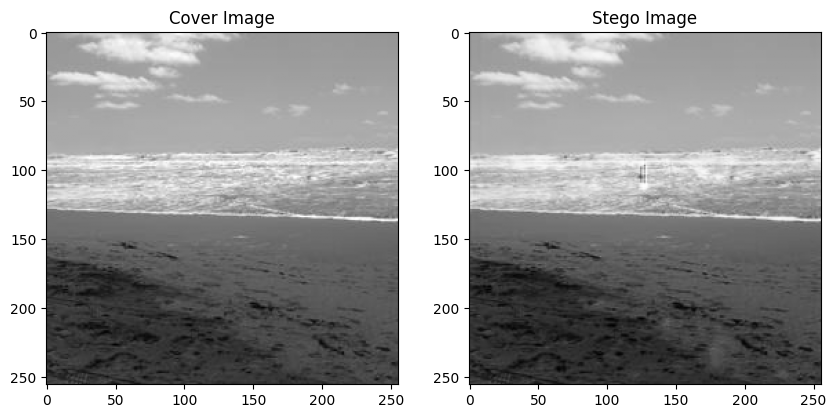

In [ ]:
# Function to generate a stego image
def generate_stego_image(generator, cover_image, message):
    cover_image = np.expand_dims(cover_image, axis=0)  # Add batch dimension
    message = message.reshape(1, -1)   # Add batch dimension

    stego_image = generator.predict([cover_image, message])
    stego_image = np.squeeze(stego_image, axis=0)  # Remove batch dimension

    return stego_image


stego_image = generate_stego_image(generator, cover_images[4000], binary_messages[1000])

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cover_images[4000].squeeze(), cmap='gray')
plt.title("Cover Image")
plt.subplot(1, 2, 2)
plt.imshow(stego_image, cmap='gray')
plt.title("Stego Image")
plt.show()

In [ ]:
test_loss = generator_mse_loss_fn(cover_images[4000], stego_image)
print(f"Generator Loss: {test_loss}")

Generator Loss: 0.0003362397837918252


In [ ]:
import random
import json
def correct_errors(original_message, min_errors=1, max_errors=5):

    corrupted = original_message.copy()
    error_report = {"errors_detected": []}

    num_errors = random.randint(min_errors, max_errors)
    fields_available = list(original_message.keys())

    if 'lab_results' in original_message:
        fields_available.extend([f'lab_results.{k}' for k in original_message['lab_results'].keys()])

    num_errors = min(num_errors, len(fields_available))

    fields_to_corrupt = random.sample(fields_available, num_errors)

    for field in fields_to_corrupt:
        # Handle nested fields
        if field.startswith('lab_results.'):
            subfield = field.split('.')[1]
            original_value = corrupted['lab_results'][subfield]
        else:
            original_value = corrupted[field]

        if isinstance(original_value, (int, float)):
            # Numerical corruption
            if field == 'age' or field == 'lab_results.heart_rate':
                variation = random.choice([-2, -1, 1, 2])
                new_value = original_value + variation
                new_value = max(0, new_value)
            elif field == 'lab_results.hemoglobin':
                variation = random.uniform(-0.5, 0.5)
                new_value = original_value + variation
                new_value = max(0, new_value)
            elif field == 'lab_results.blood_pressure':
                if isinstance(original_value, str) and '/' in original_value:
                    systolic, diastolic = original_value.split('/')
                    try:
                        systolic = str(int(systolic) + random.choice([-3, -2, -1, 1, 2, 3]))
                        diastolic = str(int(diastolic) + random.choice([-3, -2, -1, 1, 2, 3]))
                        new_value = f"{systolic}/{diastolic}"
                    except ValueError:
                        new_value = original_value
                else:
                    new_value = original_value
            else:
                new_value = original_value + random.choice([-1, 0, 1])

            if field.startswith('lab_results.'):
                corrupted['lab_results'][subfield] = new_value
            else:
                corrupted[field] = new_value

            error_report["errors_detected"].append({
                "field": field,
                "type": "numerical_variation",
                "original": original_value,
                "corrupted": new_value
            })
        else:
            # Text corruption
            text_value = str(original_value)
            if len(text_value) == 0:
                continue

            # Choose a random position to corrupt
            pos = random.randint(0, len(text_value)-1)
            original_char = text_value[pos]

            if original_char.isalpha():
                new_char = random.choice('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')
                new_char = new_char.upper() if original_char.isupper() else new_char.lower()
            elif original_char.isdigit():
                new_char = random.choice('0123456789')
            else:
                new_char = random.choice('!@#$%^&*()-_=+[{]}\\|;:\'",<.>/? ')

            new_value = text_value[:pos] + new_char + text_value[pos+1:]

            if field.startswith('lab_results.'):
                corrupted['lab_results'][subfield] = new_value
            else:
                corrupted[field] = new_value

            error_report["errors_detected"].append({
                "field": field,
                "type": "character_mismatch",
                "position": pos,
                "full_original": original_value,
                "full_corrupted": new_value
            })

    return json.dumps(corrupted, indent=2), json.dumps(error_report, indent=2)

In [ ]:
def extract_message(stego_image):
    stego_image = np.expand_dims(stego_image, axis=0)
    extracted_message = extractor.predict(stego_image)
    extracted_message = np.round(extracted_message).astype(np.uint8)
    return extracted_message.squeeze()
def count_bit_errors(original,extracted):
    original = original.flatten()
    extracted = extracted.flatten()
    bit_errors = np.sum(original != extracted)
    return bit_errors

extracted_message = extract_message(stego_image)
ber = ber_loss_fn(binary_messages[1000], extracted_message)
print(f"bit error rate:{ber}")

decoded_message = decode_patient_info(extracted_message)
original_message = decode_patient_info(binary_messages[1000])

corrupted_json, error_report_json = correct_errors(original_message)

print("\nOriginal Message:")
print(json.dumps(original_message, indent=2))

print("\nExtracted Message:")
print(corrupted_json)

print("\nError Report:")
print(error_report_json)

# print("\nExtracted Message:")
# print(json.dumps(decoded_message, indent=2))

# print(f"\nextracted binary: {extracted_message.flatten()}")
print(f"original binary: {binary_messages[1000].flatten()}")
print(f"number of bit errors: {count_bit_errors(binary_messages[1000], extracted_message)/2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
bit error rate:0.03173828125

Original Message:
{
  "patient_id": 36991565,
  "age": 77,
  "gender": "F",
  "blood_type": "O-",
  "allergies": "traditional,space,political\u0000\u0000\u0000",
  "chronic_conditions": "plant,indicate,nor,truth,paper\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000",
  "current_medications": "Agency begin treat media director or mean him.,Condition manager should believe",
  "recent_treatments": "Call next lay magazine.,Forward black accept since visit dinner.,Moment mention",
  "hospital_visits": "2021-06-26,2021-06-21,2024-04-15\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000\u0000",
  "lab_results": {
    "hemoglobin": 10.300000190734863,
    "cholesterol": 227.0,
    "blood_pressure": "113/78",
    "heart_rate": 76
  }
}

Extracted Message:
{
  "patient_id": 36991565,
  "age": 77,
  "gender

In [ ]:
import matplotlib.pyplot as plt
def display_samples(cover_images, num_samples=20, images_per_row=4):
    """Displays sample images from the cover_images array."""
    num_samples = min(num_samples, len(cover_images))
    indices = np.random.choice(len(cover_images), num_samples, replace=False)
    rows = (num_samples + images_per_row - 1) // images_per_row

    plt.figure(figsize=(15, 5 * rows))
    for i, idx in enumerate(indices):
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(cover_images[idx], cmap='gray')  # Change cmap if images are RGB
        plt.axis('off')
        plt.title(f"Sample {i+1}")
    plt.show()
display_samples(cover_images, num_samples=20)


In [ ]:
print("Message Samples:")

message = generate_patient_info()
print("Original Message sample:")
for key, value in message.items():
    print(f"{key}: {value}")

print(f"\nMessage shape: {binary_messages[1].shape}")
print(binary_messages[1])


Message Samples:
Original Message sample:
patient_id: c815311a-1341-4f37-bcba-fc37f3348d5b
age: 84
gender: Female
blood_type: O-
allergies: ['crime', 'picture', 'management']
chronic_conditions: ['those', 'agreement', 'series', 'month', 'once']
current_medications: ['Reality example friend.', 'Hit research take.', 'Trouble century career.', 'Yet several.', 'Former structure hear trip.']
recent_treatments: ['Situation challenge imagine tend prepare.', 'Summer of remember almost.', 'Medical star sea like.', 'East add former compare.', 'Trip training specific particularly PM view main debate.']
hospital_visits: ['2021-04-15', '2020-06-04', '2024-06-30', '2022-05-10', '2024-12-18']
lab_results: {'hemoglobin': 14.6, 'cholesterol': 216.1, 'blood_pressure': '106/77', 'heart_rate': 71}

Message shape: (16384,)
[0 1 1 ... 0 0 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Discriminator Prediction: 0.45678887


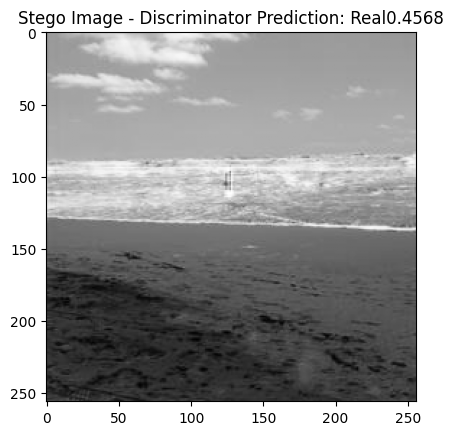

In [ ]:
def test_stego_image(discriminator, stego_image):
    stego_image = np.expand_dims(stego_image, axis=0)  # Add batch dimension

    prediction = discriminator.predict(stego_image)
    prediction_label = "Stego" if prediction[0][0] > 0.5 else "Real"
    return prediction_label, prediction[0][0]
    return prediction

prediction_label, prediction_score= test_stego_image(discriminator, stego_image)
print("Discriminator Prediction:", prediction_score)
plt.imshow(stego_image, cmap='gray')
plt.title(f"Stego Image - Discriminator Prediction: {prediction_label}{prediction_score:.4f}")
plt.show()


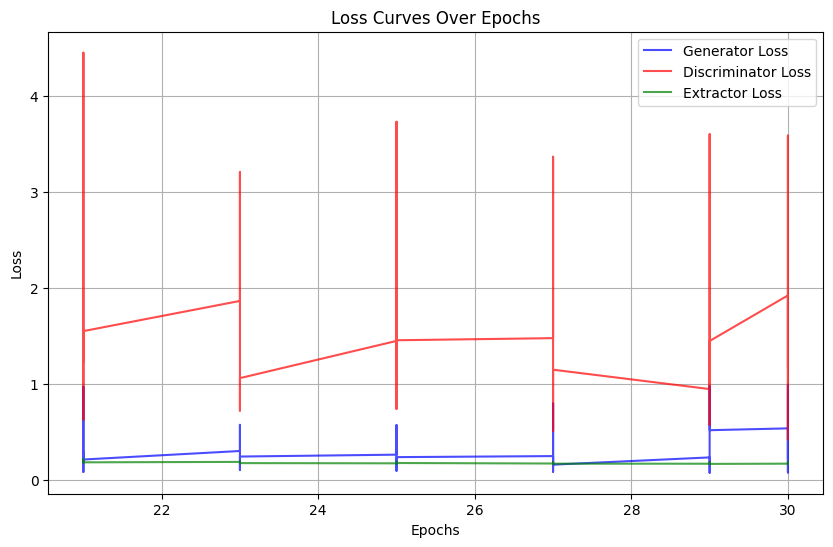

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss curves
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

loss_df=pd.read_csv("/content/drive/MyDrive/CIP/Loss_Values/loss_values.csv")
plt.plot(loss_df["Epoch"], loss_df["Gen Loss"], label="Generator Loss", color='blue', alpha=0.7)
plt.plot(loss_df["Epoch"], loss_df["Disc Loss"], label="Discriminator Loss", color='red', alpha=0.7)
plt.plot(loss_df["Epoch"], loss_df["Extractor Loss"], label="Extractor Loss", color='green', alpha=0.7)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves Over Epochs")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


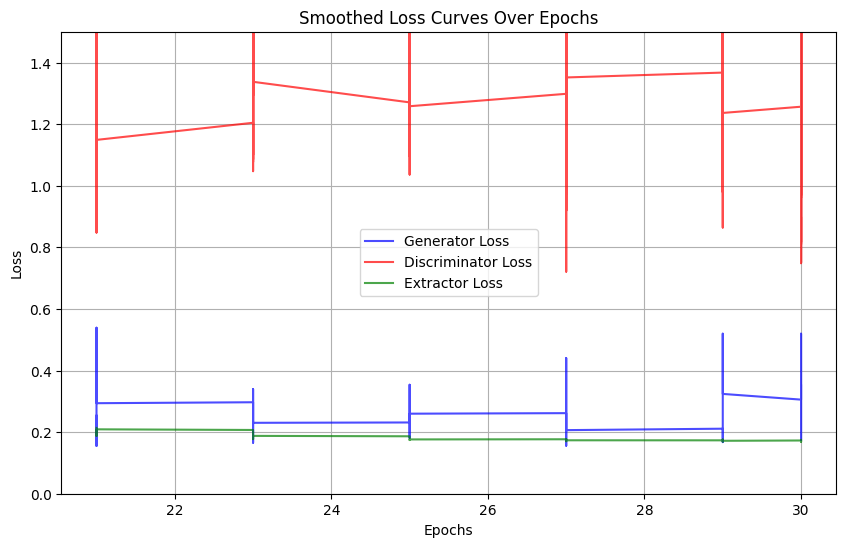

In [ ]:
window_size = 10
loss_df_sorted = loss_df.sort_values("Epoch")  # Ensure proper ordering
loss_df_smoothed = loss_df_sorted.rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(10, 6))

plt.plot(loss_df_sorted["Epoch"], loss_df_smoothed["Gen Loss"], label="Generator Loss", color='blue', alpha=0.7)
plt.plot(loss_df_sorted["Epoch"], loss_df_smoothed["Disc Loss"], label="Discriminator Loss", color='red', alpha=0.7)
plt.plot(loss_df_sorted["Epoch"], loss_df_smoothed["Extractor Loss"], label="Extractor Loss", color='green', alpha=0.7)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Smoothed Loss Curves Over Epochs")
plt.legend()
plt.grid(True)

# Adjust y-axis limits to focus on small fluctuations (assuming losses are between 0 and 1.5)
plt.ylim(0, 1.5)

plt.show()

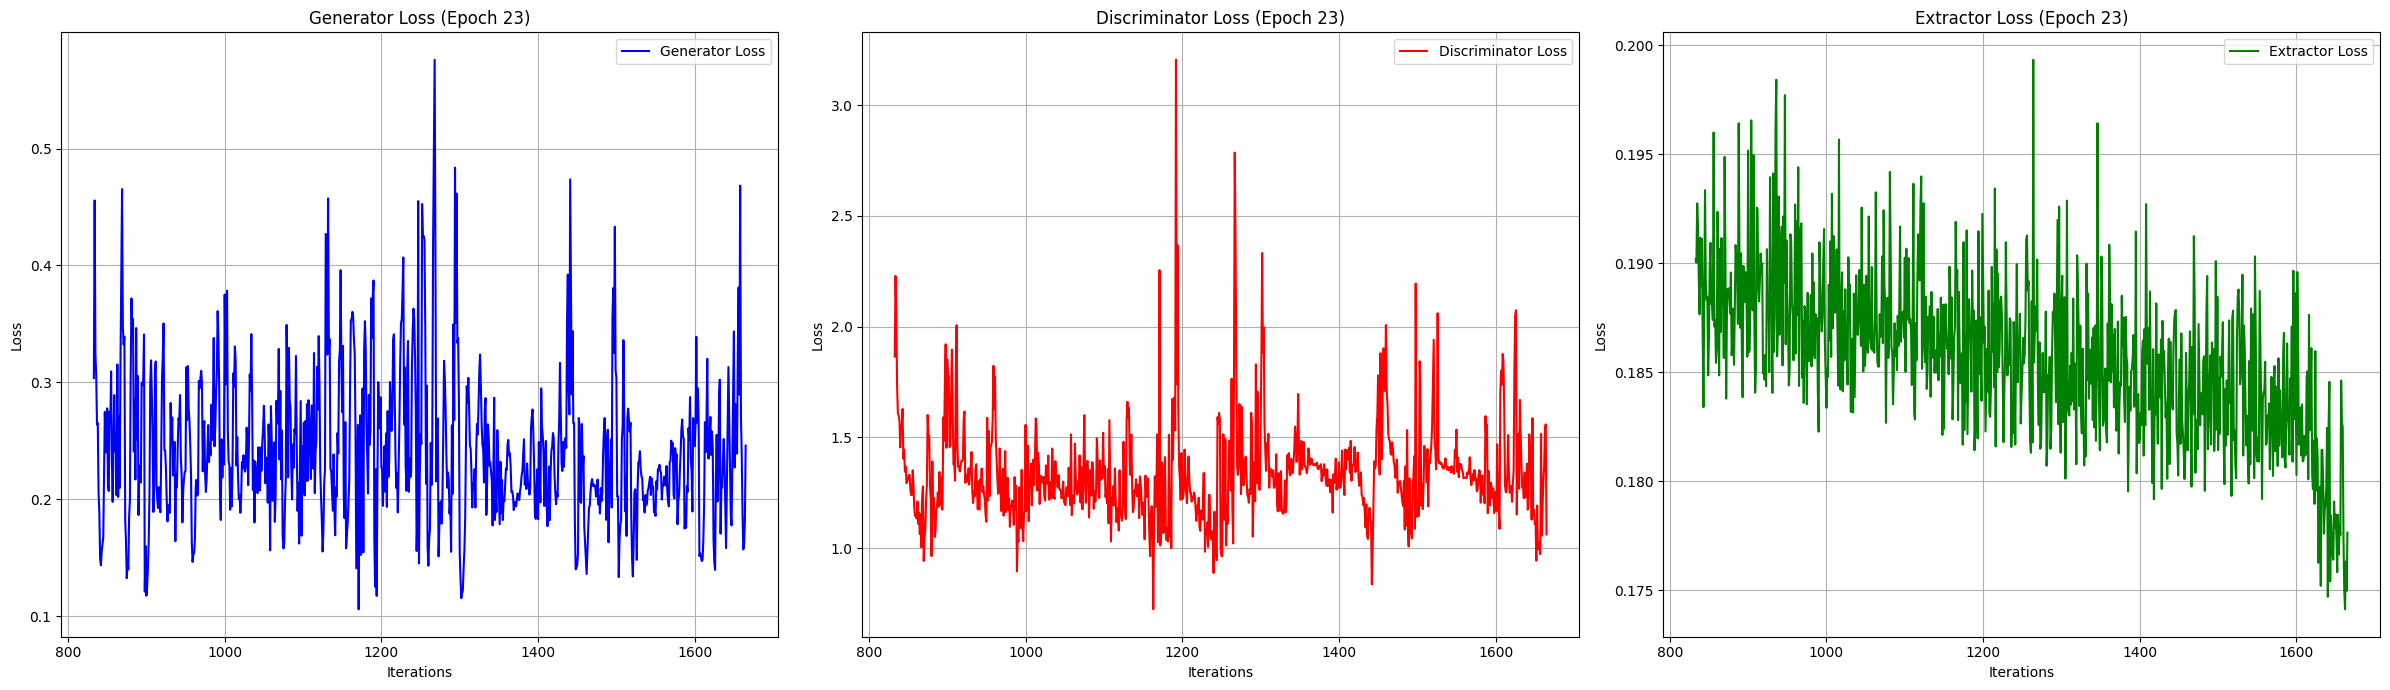

In [ ]:
import matplotlib.pyplot as plt

# Select a specific epoch (e.g., epoch 50)
epoch_number = 23
epoch_data = loss_df[loss_df["Epoch"] == epoch_number]  # Filter data for the chosen epoch

plt.figure(figsize=(24, 7))

# Generator Loss
plt.subplot(1, 3, 1)
plt.plot(epoch_data.index, epoch_data["Gen Loss"], label="Generator Loss", color="blue")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title(f"Generator Loss (Epoch {epoch_number})")
plt.legend()
plt.grid(True)

# Discriminator Loss
plt.subplot(1, 3, 2)
plt.plot(epoch_data.index, epoch_data["Disc Loss"], label="Discriminator Loss", color="red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title(f"Discriminator Loss (Epoch {epoch_number})")
plt.legend()
plt.grid(True)

# Extractor Loss
plt.subplot(1, 3, 3)
plt.plot(epoch_data.index, epoch_data["Extractor Loss"], label="Extractor Loss", color="green")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title(f"Extractor Loss (Epoch {epoch_number})")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


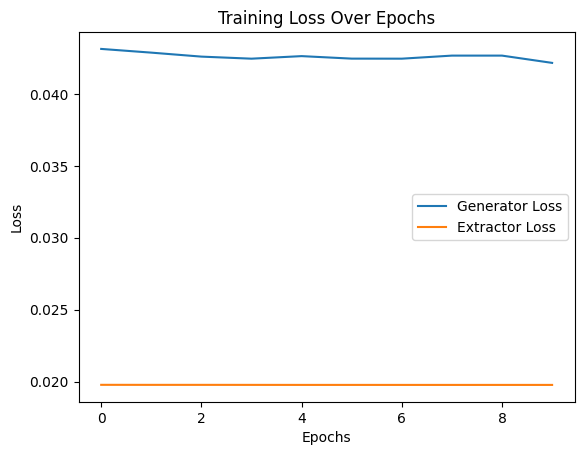

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load loss history
with open("/content/drive/MyDrive/CIP/Saved_Models/new3/training_history.pkl", "rb") as f:
    history = pickle.load(f)

# Plot loss curves
plt.plot(history["generator_loss"], label="Generator Loss")
# plt.plot(history["discriminator_loss"], label="Discriminator Loss")
plt.plot(history["extractor_loss"], label="Extractor Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Over Epochs")
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

total_gen_loss, total_disc_acc, total_msg_acc, total_ber_loss = 0, 0, 0, 0
num_batches = 0

for batch_cover, batch_message in dataset:

    stego_images = generator([batch_cover,batch_message])

    real_output = discriminator(batch_cover)
    fake_output = discriminator(stego_images)

    extracted_messages = extractor(stego_images)

    gen_loss = tf.keras.losses.MeanSquaredError()(batch_cover, stego_images).numpy()

    real_acc = np.mean((real_output.numpy() > 0.5).astype(int) == 1)
    fake_acc = np.mean((fake_output.numpy() < 0.5).astype(int) == 1)
    disc_acc = (real_acc + fake_acc) / 2

    # msg_acc = np.mean((tf.round(batch_message) == tf.round(extracted_messages)).numpy().astype(np.float32))
    msg_acc = np.mean((tf.round(batch_message) == tf.round(tf.cast(extracted_messages, tf.uint8))).numpy().astype(np.float32))
    ber_loss = ber_loss_fn(batch_message, extracted_messages).numpy()

    total_gen_loss += gen_loss
    total_disc_acc += disc_acc
    total_msg_acc += msg_acc
    total_ber_loss += ber_loss
    num_batches += 1

avg_gen_loss = total_gen_loss / num_batches
avg_disc_acc = total_disc_acc / num_batches
avg_msg_acc = total_msg_acc / num_batches
avg_ber_loss = total_ber_loss / num_batches

print("\nModel Evaluation Results")
print(f"Generator Loss: {avg_gen_loss:.6f}")
print(f" Discriminator Accuracy: {avg_disc_acc:.4f}")
print(f" Message Retrieval Accuracy: {avg_msg_acc:.4f}")
print(f" BER Loss: {avg_ber_loss:.6f}")


Model Evaluation Results
Generator Loss: 0.001208
 Discriminator Accuracy: 0.5010
 Message Retrieval Accuracy: 0.9409
 BER Loss: 0.040113


In [ ]:
!pip install scikit-image


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
from scipy.fft import fft2, fftshift
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# ===================== Attacks ======================= #

def apply_jpeg_compression(image, quality=25):
    """Simulates JPEG compression artifacts."""
    _, encimg = cv2.imencode('.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    decimg = cv2.imdecode(encimg, 0)
    return decimg

def add_gaussian_noise(image, var=0.001):
    noisy = random_noise(image, mode='gaussian', var=var)
    return (noisy * 255).astype(np.uint8)

# ==================== Metrics ======================== #

def evaluate_metrics(original, attacked):
    # Convert to float32 and normalize to [0, 1]
    original = original.astype(np.float32)
    attacked = attacked.astype(np.float32)

    if original.max() > 1.0:
        original /= 255.0
    if attacked.max() > 1.0:
        attacked /= 255.0

    # Compute metrics
    p = psnr(original, attacked, data_range=1.0)
    s = ssim(original, attacked, data_range=1.0)
    return p, s

# ==================== FFT Visual ===================== #

def get_fft_spectrum(image):
    f = fftshift(np.abs(fft2(image)))
    return np.log1p(f)

# ==================== Master Function ===================== #

def visualize_attacks(original_img):
    if original_img.ndim == 3:
        original_img = original_img.squeeze()

    # Normalize if needed
    if original_img.max() > 1.0:
        norm_img = original_img / 255.0
    else:
        norm_img = original_img

    # Attacks
    jpeg_img = apply_jpeg_compression((norm_img * 255).astype(np.uint8))
    gaussian_img = add_gaussian_noise(norm_img)


    images = [original_img, jpeg_img, gaussian_img]
    labels = ['Original', 'JPEG', 'Gaussian']

    metrics = {}

    for name, img in zip(labels[1:], images[1:]):
        p, s = evaluate_metrics(original_img, img)
        metrics[name] = {'PSNR': p, 'SSIM': s}
        print(f"{name} => PSNR: {p:.2f}, SSIM: {s:.3f}")


    # # Plot
    # fig, axs = plt.subplots(2, 3, figsize=(20, 8))
    # for i in range(3):
    #     axs[0, i].imshow(images[i], cmap='gray')
    #     axs[0, i].set_title(labels[i])
    #     axs[0, i].axis('off')

    #     axs[1, i].imshow(get_fft_spectrum(images[i]), cmap='inferno')
    #     axs[1, i].set_title(f"{labels[i]} FFT")
    #     axs[1, i].axis('off')

    # plt.tight_layout()
    # plt.show()
    return metrics


In [ ]:

stego_image = generate_stego_image(generator, cover_images[1000], binary_messages[1000])
print(f"stego image :{stego_image.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
stego image :(256, 256, 1)


In [ ]:
import numpy as np

# Store metrics for all images
all_metrics = {
    'JPEG': {'PSNR': [], 'SSIM': []},
    'Gaussian': {'PSNR': [], 'SSIM': []}
}

random_indices = np.random.choice(len(cover_images), 30, replace=False)
stego_images = []

for idx in random_indices:
    cover = cover_images[idx]
    message = binary_messages[idx]

    # Generate stego image
    stego_image = generate_stego_image(generator, cover, message)
    stego_images.append(stego_image)

    # Get attack metrics
    metrics = visualize_attacks(stego_image.squeeze())  # Make sure it's 2D (256x256)

    # Accumulate results
    for attack_type in metrics:
        all_metrics[attack_type]['PSNR'].append(metrics[attack_type]['PSNR'])
        all_metrics[attack_type]['SSIM'].append(metrics[attack_type]['SSIM'])

# After loop: compute averages
for attack_type in all_metrics:
    psnr_avg = np.mean(all_metrics[attack_type]['PSNR'])
    ssim_avg = np.mean(all_metrics[attack_type]['SSIM'])
    print(f"\n📊 {attack_type} (Avg over 30 images) => PSNR: {psnr_avg:.2f}, SSIM: {ssim_avg:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
JPEG => PSNR: 28.03, SSIM: 0.829
Gaussian => PSNR: 30.02, SSIM: 0.886
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
JPEG => PSNR: 31.56, SSIM: 0.903
Gaussian => PSNR: 29.98, SSIM: 0.686
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
JPEG => PSNR: 30.62, SSIM: 0.911
Gaussian => PSNR: 31.62, SSIM: 0.684
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
JPEG => PSNR: 34.77, SSIM: 0.919
Gaussian => PSNR: 30.37, SSIM: 0.699
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
JPEG => PSNR: 29.53, SSIM: 0.933
Gaussian => PSNR: 30.04, SSIM: 0.843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
JPEG => PSNR: 29.34, SSIM: 0.898
Gaussian => PSNR: 30.35, SSIM: 0.771
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
JPEG => PSNR: 27.33, SSIM: 0.870
Gaussian => PSNR: 30.02, SSIM: 0.873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
JPEG => PSNR: 33.32, SSIM: 0.915
Gaussian => PSNR: 30.13, SSIM: 0.698
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
JPEG => PSNR: 34.10, SSIM: 0.914
Gaussian => PSNR: 30.09, SSIM: 0.715
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

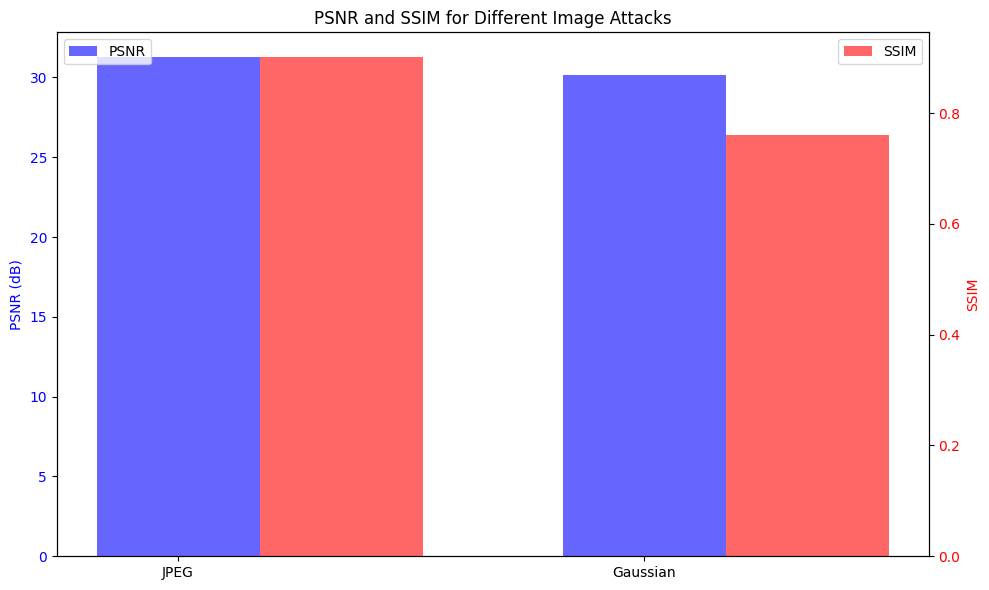

In [ ]:
labels = ['JPEG', 'Gaussian']
# psnr_values = [m[0] for m in metrics]  # Extract PSNR values
# ssim_values = [m[1] for m in metrics]  # Extract SSIM values
# print(f"psnr_values:{psnr_values}")
# print(f"ssim_values:{ssim_values}")
# psnr_values = [float(p) for p in psnr_values]  # Converts to Python float
# ssim_values = [float(s) for s in ssim_values]  # Converts to Python float

psnr_values = [np.mean(all_metrics[attack_type]['PSNR']) for attack_type in labels]
ssim_values = [np.mean(all_metrics[attack_type]['SSIM']) for attack_type in labels]
# for attack_type in all_metrics:
#     psnr_avg = np.mean(all_metrics[attack_type]['PSNR'])
#     ssim_avg = np.mean(all_metrics[attack_type]['SSIM'])
bar_width=0.35
# Define the bar positions
x = np.arange(len(labels))  # Positions for the bars

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot PSNR values
bar_width = 0.35
ax1.bar(x, psnr_values, width=bar_width, label='PSNR', color='b', alpha=0.6)
ax1.set_ylabel('PSNR (dB)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)  # Set x-tick labels

# Create another y-axis for SSIM
ax2 = ax1.twinx()
ax2.bar(x + bar_width, ssim_values, width=bar_width, label='SSIM', color='r', alpha=0.6)
ax2.set_ylabel('SSIM', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Adding title and legend
plt.title('PSNR and SSIM for Different Image Attacks')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [ ]:
# Simple architecture idea
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def steganalysis_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 1)),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary
    ])
    return model


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


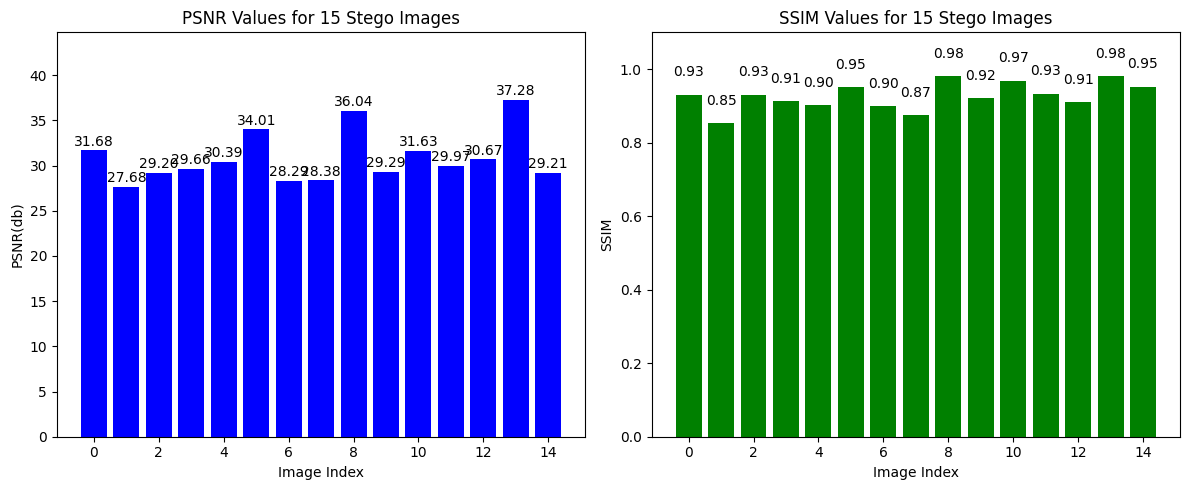

In [ ]:
# prompt: Generate 15 stego images from the cover and compare the PSNR and SSIM of both cover and stego image

import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import numpy as np

def generate_stego_image(generator, cover_image, message):
    cover_image = np.expand_dims(cover_image, axis=0)  # Add batch dimension
    message = message.reshape(1, -1)   # Add batch dimension

    stego_image = generator.predict([cover_image, message])
    stego_image = np.squeeze(stego_image, axis=0)  # Remove batch dimension

    return stego_image
def evaluate_metrics(original, Stego):
    original = original.astype(np.float32)
    attacked = Stego.astype(np.float32)
    original=original.squeeze()
    attacked=attacked.squeeze()
    if original.max() > 1.0:
        original /= 255.0
    if attacked.max() > 1.0:
        attacked /= 255.0

    # Compute metrics
    p = psnr(original, attacked, data_range=1.0)
    s = ssim(original, attacked, data_range=1.0)
    return p, s


# Generate 15 stego images and store metrics
num_stego_images = 15
psnr_values = []
ssim_values = []

for i in range(num_stego_images):
    # Choose random cover and message
    random_index = np.random.randint(0, len(cover_images))
    cover_img = cover_images[random_index]
    message = binary_messages[random_index]

    # Generate stego image
    stego_img = generate_stego_image(generator, cover_img, message)

    # Calculate PSNR and SSIM
    p, s = evaluate_metrics(cover_img, stego_img)
    psnr_values.append(p)
    ssim_values.append(s)

    # Visualization (Optional: Uncomment to display each image pair)
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(cover_img.squeeze(), cmap='gray')
    # plt.title("Cover Image")
    # plt.subplot(1, 2, 2)
    # plt.imshow(stego_img, cmap='gray')
    # plt.title("Stego Image")
    # plt.show()
plt.figure(figsize=(12, 5))

# Plot 1: PSNR values
plt.subplot(1, 2, 1)
plt.bar(range(num_stego_images), psnr_values, color='blue')
plt.title('PSNR Values for 15 Stego Images')
plt.ylabel('PSNR(db)')
plt.xlabel('Image Index')
plt.ylim(0, max(psnr_values) * 1.2)  # Adjust y-axis limit
for i, v in enumerate(psnr_values):
    plt.text(i, v + 0.5, f'{v:.2f}', ha='center')

# Plot 2: SSIM values
plt.subplot(1, 2, 2)
plt.bar(range(num_stego_images), ssim_values, color='green')
plt.title('SSIM Values for 15 Stego Images')
plt.ylabel('SSIM')
plt.xlabel('Image Index')
plt.ylim(0, 1.1)  # SSIM ranges from 0 to 1
for i, v in enumerate(ssim_values):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()


In [ ]:
def extract_message(stego_image):
    stego_image = np.expand_dims(stego_image, axis=0)
    extracted_message = extractor.predict(stego_image)
    extracted_message = np.round(extracted_message).astype(np.uint8)
    return extracted_message.squeeze()
attacked=apply_jpeg_compression((stego_image).astype(np.uint8))
extract_message=extract_message(attacked)
print(f"bit error rate:{ber_loss_fn(binary_messages[1000],extract_message)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
bit error rate:0.02978515625


In [ ]:
for i in range(20):
    stego_image=generate_stego_images(generator,cover_images[i],binary_messages[i])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Image 1: BER = 0.0319, Accuracy = 0.9681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Image 2: BER = 0.0320, Accuracy = 0.9680
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image 3: BER = 0.0334, Accuracy = 0.9666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 4: BER = 0.0320, Accuracy = 0.9680
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 5: BER = 0.0322, Accuracy = 0.9678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image 6: BER = 0.0319, Accuracy = 0.9681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image 7: BER = 0.0322, Accuracy = 0.9678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image 8: BER = 0.0308, Accuracy = 0.9692
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

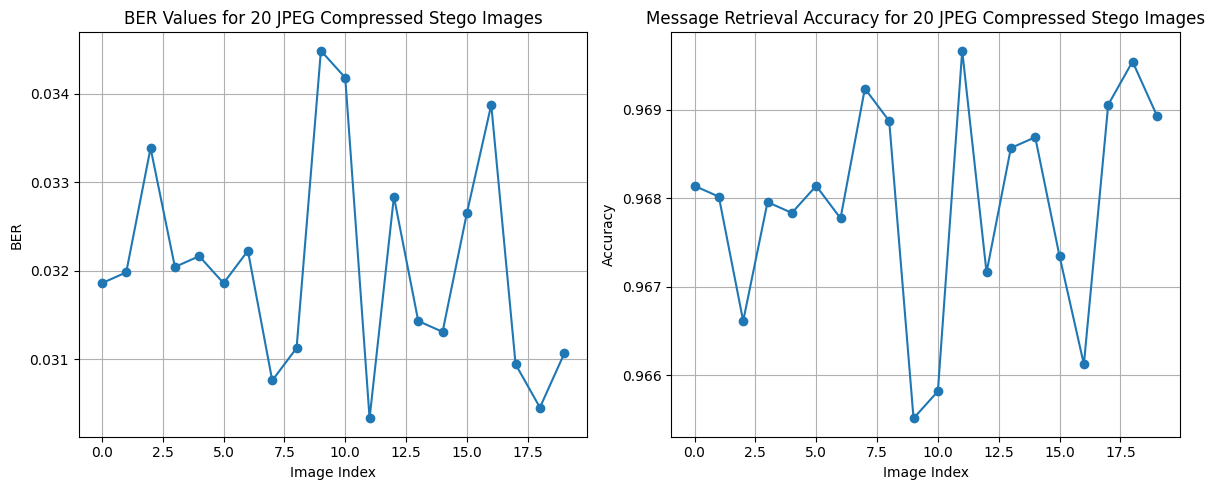

In [ ]:
def extract_message(stego_image):
    stego_image = np.expand_dims(stego_image, axis=0)
    extracted_message = extractor.predict(stego_image)
    extracted_message = np.round(extracted_message).astype(np.uint8)
    return extracted_message.squeeze()

import numpy as np
import matplotlib.pyplot as plt

num_stego_images = 20
ber_values = []
message_retrieval_accuracy = []

for i in range(num_stego_images):
    # Apply JPEG compression
    stego_images = generate_stego_image(generator, cover_images[i], binary_messages[i])
    attacked_image = apply_jpeg_compression(stego_images.astype(np.uint8))

    # Extract message from the compressed image
    # Call the extract_message function, not the variable
    extracted_message = extract_message(attacked_image)

    # Calculate BER
    ber = ber_loss_fn(binary_messages[i], extracted_message).numpy()
    ber_values.append(ber)

    # Calculate message retrieval accuracy (assuming a threshold for accuracy)
    # You'll need to adjust the threshold based on your specific needs
    accuracy = np.mean((binary_messages[i] == extracted_message).astype(np.float32))
    message_retrieval_accuracy.append(accuracy)


    print(f"Image {i+1}: BER = {ber:.4f}, Accuracy = {accuracy:.4f}")

# Plotting the results
plt.figure(figsize=(12, 5))

# Plot 1: BER values
plt.subplot(1, 2, 1)
plt.plot(range(num_stego_images), ber_values, marker='o', linestyle='-')
plt.title('BER Values for 20 JPEG Compressed Stego Images')
plt.ylabel('BER')
plt.xlabel('Image Index')
plt.grid(True)

# Plot 2: Message Retrieval Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_stego_images), message_retrieval_accuracy, marker='o', linestyle='-')
plt.title('Message Retrieval Accuracy for 20 JPEG Compressed Stego Images')
plt.ylabel('Accuracy')
plt.xlabel('Image Index')
plt.grid(True)


plt.tight_layout()
plt.show()


In [ ]:
print(f"BER :{np.mean(ber_values)}")
print(f"Message Retrieval Accuracy :{np.mean(message_retrieval_accuracy)}")

BER :0.03204955905675888
Message Retrieval Accuracy :0.9679504632949829


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image 1: BER = 0.0319, Accuracy = 0.9681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image 2: BER = 0.0320, Accuracy = 0.9680
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image 3: BER = 0.0334, Accuracy = 0.9666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image 4: BER = 0.0320, Accuracy = 0.9680
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 5: BER = 0.0322, Accuracy = 0.9678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 6: BER = 0.0319, Accuracy = 0.9681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image 7: BER = 0.0322, Accuracy = 0.9678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 8: BER = 0.0308, Accuracy = 0.9692
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

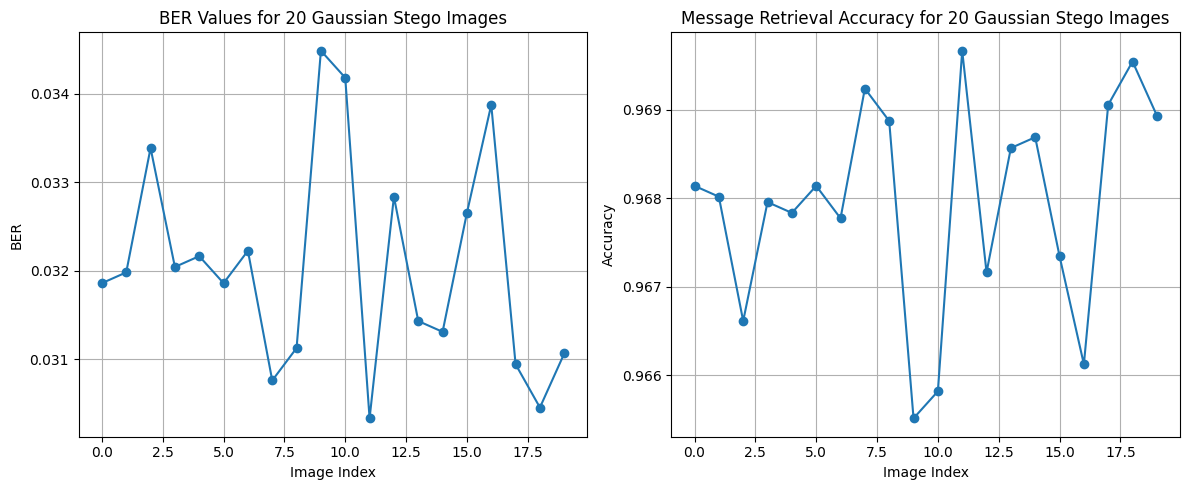

In [ ]:
def extract_message(stego_image):
    stego_image = stego_image.astype(np.float32) / 255.0
    stego_image = np.expand_dims(stego_image, axis=0)
    extracted_message = extractor.predict(stego_image)
    extracted_message = np.round(extracted_message).astype(np.uint8)
    return extracted_message.squeeze()

import numpy as np
import matplotlib.pyplot as plt

num_stego_images = 20
ber_values = []
message_retrieval_accuracy = []

for i in range(num_stego_images):
    stego_images = generate_stego_image(generator, cover_images[i], binary_messages[i])
    stego_images = stego_images.astype(np.float32) / 255.0
    attacked_image = add_gaussian_noise(stego_images.astype(np.uint8))

    extracted_message = extract_message(attacked_image)

    ber = ber_loss_fn(binary_messages[i], extracted_message).numpy()
    ber_values.append(ber)

    accuracy = np.mean((binary_messages[i] == extracted_message).astype(np.float32))
    message_retrieval_accuracy.append(accuracy)


    print(f"Image {i+1}: BER = {ber:.4f}, Accuracy = {accuracy:.4f}")

# Plotting the results
plt.figure(figsize=(12, 5))

# Plot 1: BER values
plt.subplot(1, 2, 1)
plt.plot(range(num_stego_images), ber_values, marker='o', linestyle='-')
plt.title('BER Values for 20 Gaussian Stego Images')
plt.ylabel('BER')
plt.xlabel('Image Index')
plt.grid(True)

# Plot 2: Message Retrieval Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_stego_images), message_retrieval_accuracy, marker='o', linestyle='-')
plt.title('Message Retrieval Accuracy for 20 Gaussian Stego Images')
plt.ylabel('Accuracy')
plt.xlabel('Image Index')
plt.grid(True)


plt.tight_layout()
plt.show()


In [ ]:
print(f"BER :{np.mean(ber_values):.4f}")
print(f"Message Retrieval Accuracy :{np.mean(message_retrieval_accuracy):.4f}")

BER :0.0320
Message Retrieval Accuracy :0.9680
